# DES Y6 Metadetection Cuts and Analysis

This notebook has some basic examples, current default cuts, and an example response computation for DES Y6 metadetection catalogs.


## Overview of Metadetection

Metadetection is a technique where we include the object detection step in metacalibration. This change is needed because object detection appears to depend on the applied shear. Our Y3 pipelines only computed the response at fixed detections and so missed this crucial effect. 

For Y6, the metadetection pipeline works as follows:

1. We create "pizza slice" coadds which are small, 200x200 square-cut slices of each coadd tile. We recoadd the data starting with the single epoch images, rejecting any image with an edge in the pizza slice. This procedure keeps the PSF exactly continuous across the pizza slice.

2. For each pizza slice, we deconvolve the PSF at the center, apply one of the five metacalibration shears (`noshear`, `1p`, `1m`, `2p`, `2m`), and then reconvolve the image with a slightly larger, round PSF.

3. Then, for each of the five metacalibration images per slice, we rerun source extractor detection and measure the shapes of the detected objects.

4. Finally, we combine all of the catalogs, recording which metacalibration shear is associated with each detection.


## Metadetection Response Computations

Given the setup above, we can then compute the mean shear of the image as follows. For each of the five metacalibration shears we select all detections associated with that shear, make any cuts, and then compute the mean shape of the detections. Let's call this quantity $\langle g_i \rangle_{\alpha}$ where $\alpha\in\{{\rm noshear}, 1p, 1m, 2p, 2m\}$. Then, for example, the metadetection response of $g_1$ to a shear on the 1-axis is

$$
R_{11} = \frac{\langle g_1 \rangle_{1p} - \langle g_1 \rangle_{1m}}{2\Delta\gamma} 
$$

Finally, the estimator for the mean shear is 

$$
{\hat g_1} = \frac{\langle g_1 \rangle_{\rm noshear}}{R_{11}}
$$

where we have neglected off diagonal repsonse effects as usual. 


## The Dos and Don'ts of Metadetection

1. Do take the catalogs for a test drive!
2. Don't match the catalogs to other catalogs (e.g., gold). If you match the catalogs and only keep the matches, then you have reimparted the selection without shear dependence and the response will be wrong.
3. Do match the catalogs to do simple sanity checks (e.g., does this magnitude column make sense? why are these objects so funny?)
4. Don't make different cuts on each catalog. In order for the metadetection response to be correct, you have to make the same cuts on each catalog. So if you match one of the catalogs to a systematic map, then you have to match each one to the map and make the same cut on each.

## Let's Take a Look!

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set()

In [2]:
import numpy as np
import fitsio

In [3]:
d = fitsio.read("/Users/beckermr/Downloads/DES0007-5957_metadetect-v3_mdetcat_part0000.fits")

The catalog has columns of course!

In [4]:
for col in d.dtype.names:
    print(col)

slice_id
mdet_step
ra
dec
ra_det
dec_det
row_det
col_det
row
col
slice_row
slice_col
slice_row_det
slice_col_det
flags
mdet_flags
mdet_s2n
mdet_T
mdet_T_err
mdet_g
mdet_g_cov
psf_g
psf_T
mdet_T_ratio
mdet_band_flux_flags
mdet_band_flux
mdet_band_flux_err
ormask
mfrac
bmask
psfrec_flags
psfrec_g
psfrec_T


Let's focus on a few of the ones we really care about.

 - `mdet_step`: one of `['1m', '1p', '2m', '2p', 'noshear']` denoting which shear was applied
 - `mdet_g`: the measure shear
 - `mdet_T_ratio`: the ratio of the area of the object to the reconvolved area of the PSF
 - `mdet_s2n`: the S/N of the detection
 - `flags`: total flags for the shear measurement
 - `ra`, `dec`: positions of the objects at their effective positions in the original image (i.e., 
   for the `1p` catalog, the positions are sheared back)
 - `psfrec_g`: the shape of the original PSF
 - `psfrec_T`: the area of the original PSF
 - `psfrec_flags`: flags for the original PSF measurement
 - `mfrac`: the fraction of the object that is composed of masked images computed in a 1.2 FWHM arcsec Gaussian 
   aperture
 - `mdet_band_flux`: the fluxes in each band - this column can include bands not used for shear, but doesn't yet
 - `mdet_band_flux_flags`: the combined flags for all of the band flux measurements
 
And now plots

<IPython.core.display.Javascript object>


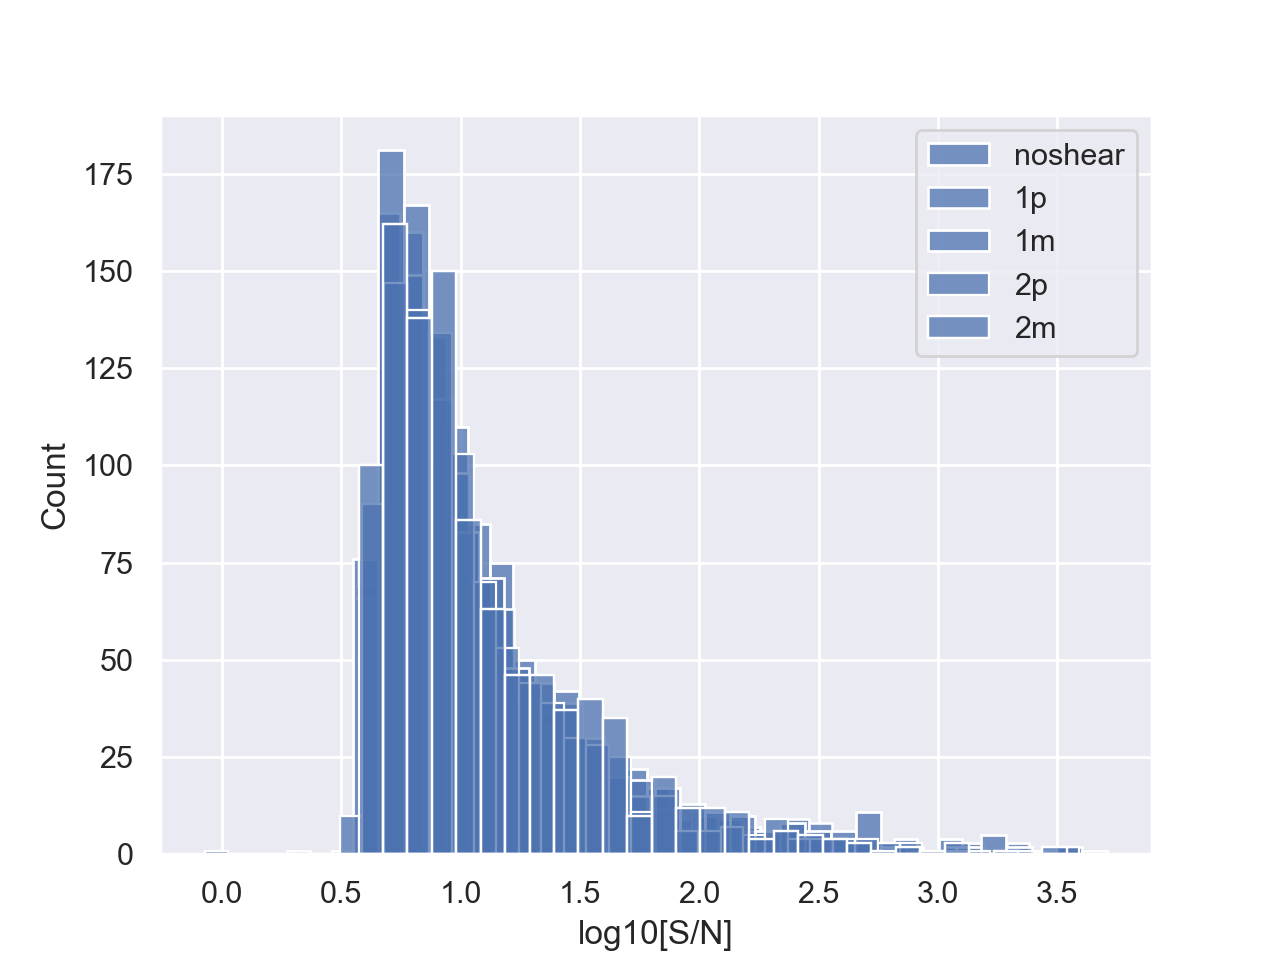

In [16]:
fig, axs = plt.subplots()

for shear in ['noshear', '1p', '1m', '2p', '2m']:
    msk = (
        (d['mdet_step'] == shear)
        & (d['flags'] == 0)
        & (d['mdet_s2n'] > 0)
    )
    vals = np.random.choice(np.log10(d['mdet_s2n'][msk].astype("<f4")), size=1000)
    sns.histplot(vals, kde=False, ax=axs, label=shear)
    axs.set_xlabel("log10[S/N]")
    axs.legend()

<IPython.core.display.Javascript object>


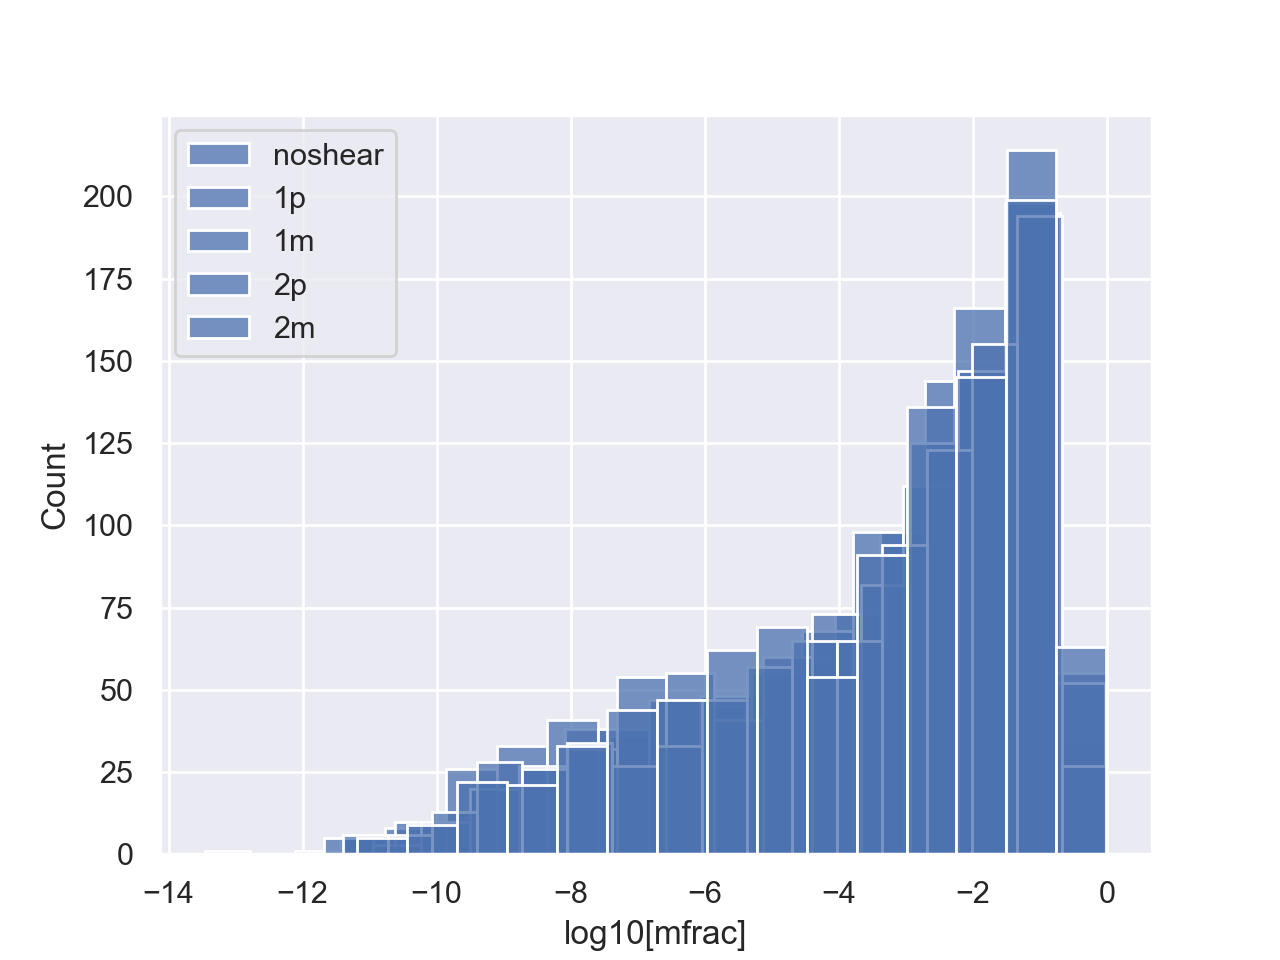

In [21]:
fig, axs = plt.subplots()

for shear in ['noshear', '1p', '1m', '2p', '2m']:
    msk = (
        (d['mdet_step'] == shear)
        & (d['flags'] == 0)
        & (d['mdet_s2n'] > 0)
        & (d['mfrac'] > 0)
        & (d['mfrac'] <= 1)
    )
    vals = np.random.choice(d['mfrac'][msk].astype("<f4"), size=1000)
    sns.histplot(np.log10(vals), kde=False, ax=axs, label=shear)
    axs.set_xlabel("log10[mfrac]")
    axs.legend()

Finally, let's use some default cuts to compute a mean shear.

In [26]:
def _make_cuts(d, shear):
    msk = (
        (d['flags'] == 0)
        & (d['mdet_s2n'] > 10)
        & (d['mdet_T_ratio'] > 1.2)
        & (d['mfrac'] < 0.1)
        & (d['mdet_step'] == shear)
    )
    return np.mean(d['mdet_g'][msk, :], axis=0)

g_noshear = _make_cuts(d, 'noshear')
g_1p = _make_cuts(d, '1p')
g_1m = _make_cuts(d, '1m')
g_2p = _make_cuts(d, '2p')
g_2m = _make_cuts(d, '2m')

R11 = (g_1p[0] - g_1m[0])/0.02
R22 = (g_2p[1] - g_2m[1])/0.02

print("g:", g_noshear[0]/R11, g_noshear[1]/R22)

g: -0.000599284154914075 0.0014594085865079552


Happy lensing!